In [1]:
import pandas as pd
import numpy as np
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
import missingno as msno
import warnings
warnings.filterwarnings('ignore')
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
from plotly.offline import iplot, init_notebook_mode
from sklearn.impute import KNNImputer,SimpleImputer
from sklearn.neighbors import LocalOutlierFactor

In [2]:
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import catboost
from catboost import CatBoostClassifier

from sklearn.metrics import precision_score,recall_score
from sklearn.metrics import f1_score

In [3]:
!pip install optuna

In [4]:
import optuna 
from optuna import Trial, visualization
from optuna.samplers import TPESampler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc

In [7]:
train = pd.read_csv('../input/spaceship-titanic/train.csv', index_col='PassengerId')
test = pd.read_csv('../input/spaceship-titanic/test.csv', index_col='PassengerId')

# Shape and preview
print('Train set shape:', train.shape)
print('Test set shape:', test.shape)
train.head()

Train set shape: (8693, 13)
Test set shape: (4277, 12)


,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
PassengerId,,,,,,,,,,,,,
0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [8]:
train.drop('Name', axis=1, inplace=True)
test.drop('Name', axis=1, inplace=True)

In [9]:
train['Transported'].replace(False, 0, inplace=True)
train['Transported'].replace(True, 1, inplace=True)

In [10]:
train[['deck','num', 'side']] = train['Cabin'].str.split('/', expand=True)
test[['deck','num', 'side']] = test['Cabin'].str.split('/', expand=True)

train.drop('Cabin', axis=1, inplace=True)
test.drop('Cabin', axis=1, inplace=True)

In [11]:
col_to_sum = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

train['SumSpends'] = train[col_to_sum].sum(axis=1)
test['SumSpends'] = test[col_to_sum].sum(axis=1)

In [12]:
train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,SumSpends
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000,8693.000000,8693.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791,0.503624,1440.866329
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189,0.500016,2803.045694
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,716.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000,1.000000,1441.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000,1.000000,35987.000000


In [14]:
test.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,SumSpends
count,4186.000000,4195.000000,4171.000000,4179.000000,4176.000000,4197.000000,4277.00000
mean,28.658146,219.266269,439.484296,177.295525,303.052443,310.710031,1417.68202
std,14.179072,607.011289,1527.663045,560.821123,1117.186015,1246.994742,2816.40210
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,714.00000
75%,37.000000,53.000000,78.000000,33.000000,50.000000,36.000000,1444.00000
max,79.000000,11567.000000,25273.000000,8292.000000,19844.000000,22272.000000,33666.00000


*Hypothesis: There are outliers in both the maximum and minimum values in each of the numerical variables. The verification of this hypothesis will be carried out in the future with an extended analysis of the data, but even now it can be assumed that the majority of passengers did not spend money on additional services.*

**What are the features in the data set?**

    PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
    HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
    CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
    Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
    Destination - The planet the passenger will be debarking to.
    Age - The age of the passenger.
    VIP - Whether the passenger has paid for special VIP service during the voyage.
    RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
    Name - The first and last names of the passenger.
    Transported - Whether the passenger was transported to another dimension.

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8693 entries, 0001_01 to 9280_02
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8492 non-null   object 
 1   CryoSleep     8476 non-null   object 
 2   Destination   8511 non-null   object 
 3   Age           8514 non-null   float64
 4   VIP           8490 non-null   object 
 5   RoomService   8512 non-null   float64
 6   FoodCourt     8510 non-null   float64
 7   ShoppingMall  8485 non-null   float64
 8   Spa           8510 non-null   float64
 9   VRDeck        8505 non-null   float64
 10  Transported   8693 non-null   int64  
 11  deck          8494 non-null   object 
 12  num           8494 non-null   object 
 13  side          8494 non-null   object 
 14  SumSpends     8693 non-null   float64
dtypes: float64(7), int64(1), object(7)
memory usage: 1.1+ MB


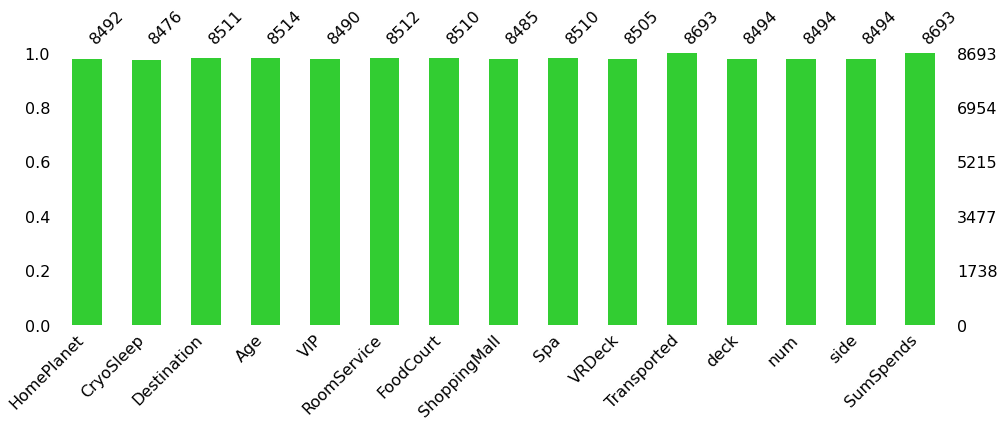

In [15]:
msno.bar(train, figsize = (16,5),color = "#32CD32")
plt.show()

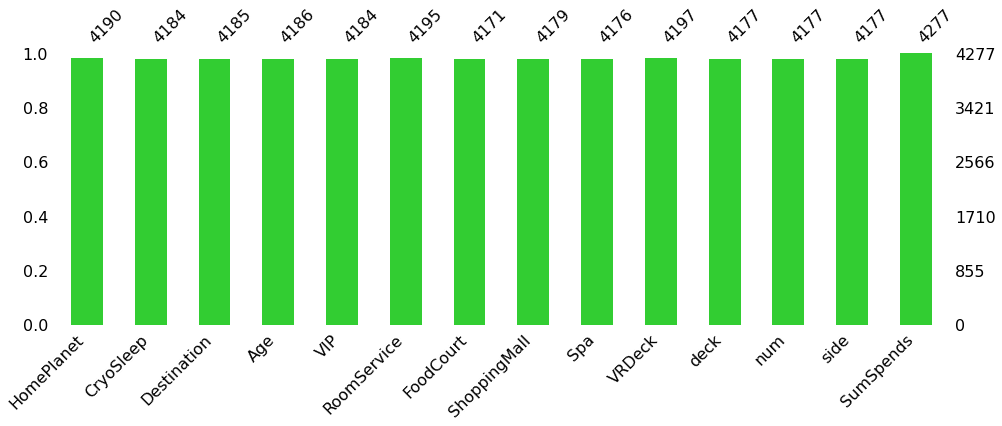

In [16]:
msno.bar(test, figsize = (16,5),color = "#32CD32")
plt.show()

In [17]:
for column_name in train.columns:
    unique_values = len(train[column_name].unique())
    print("Feature '{column_name}' has '{unique_values}' unique values".format(column_name = column_name,
                                                                                         unique_values=unique_values))

Feature 'HomePlanet' has '4' unique values
Feature 'CryoSleep' has '3' unique values
Feature 'Destination' has '4' unique values
Feature 'Age' has '81' unique values
Feature 'VIP' has '3' unique values
Feature 'RoomService' has '1274' unique values
Feature 'FoodCourt' has '1508' unique values
Feature 'ShoppingMall' has '1116' unique values
Feature 'Spa' has '1328' unique values
Feature 'VRDeck' has '1307' unique values
Feature 'Transported' has '2' unique values
Feature 'deck' has '9' unique values
Feature 'num' has '1818' unique values
Feature 'side' has '3' unique values
Feature 'SumSpends' has '2336' unique values


In [18]:
for column_name in test.columns:
    unique_values = len(test[column_name].unique())
    print("Feature '{column_name}' has '{unique_values}' unique values".format(column_name = column_name,
                                                                                         unique_values=unique_values))

Feature 'HomePlanet' has '4' unique values
Feature 'CryoSleep' has '3' unique values
Feature 'Destination' has '4' unique values
Feature 'Age' has '80' unique values
Feature 'VIP' has '3' unique values
Feature 'RoomService' has '843' unique values
Feature 'FoodCourt' has '903' unique values
Feature 'ShoppingMall' has '716' unique values
Feature 'Spa' has '834' unique values
Feature 'VRDeck' has '797' unique values
Feature 'deck' has '9' unique values
Feature 'num' has '1506' unique values
Feature 'side' has '3' unique values
Feature 'SumSpends' has '1437' unique values


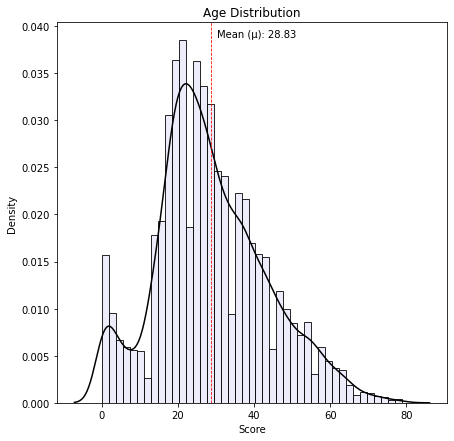

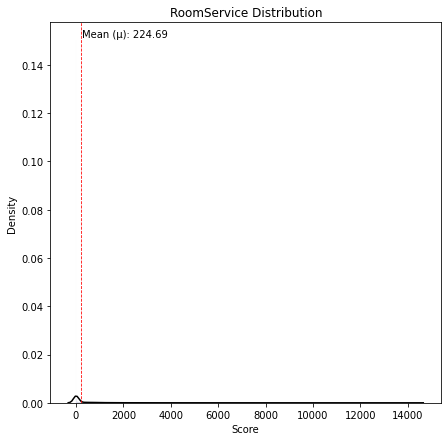

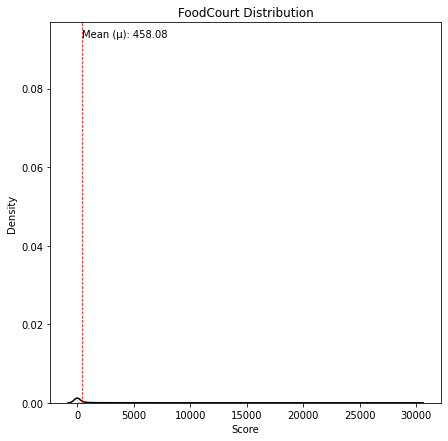

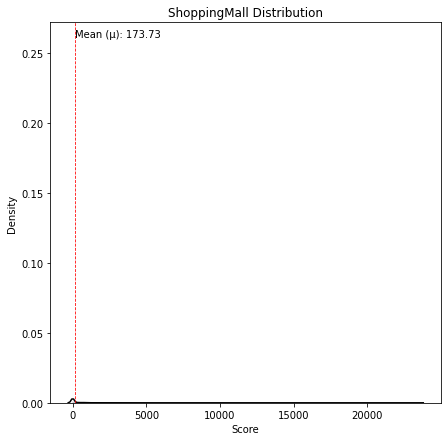

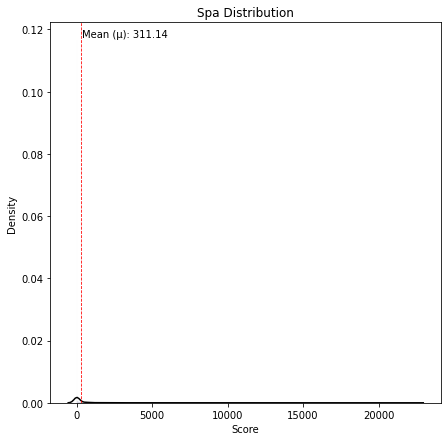

In [19]:
numeric_features=['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa']

for column_name in numeric_features:
  plt.figure(figsize=(7, 7))
  plt.title("{column_name} Distribution".format(column_name = column_name))
  sns.histplot(train[column_name], stat='density',color='#E6E6FA')
  sns.kdeplot(train[column_name], color='black')
  plt.axvline(train[column_name].mean(), color='red', linestyle='--', linewidth=0.8)
  min_ylim, max_ylim = plt.ylim()
  plt.text(train[column_name].mean()*1.05, max_ylim*0.96, 'Mean (μ): {:.2f}'.format(train[column_name].mean()))
  plt.xlabel("Score")
  plt.ylabel("Density")
  plt.show()

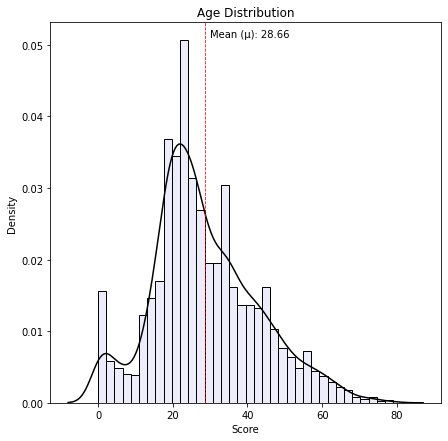

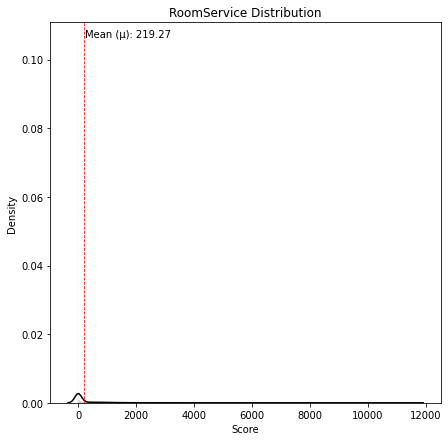

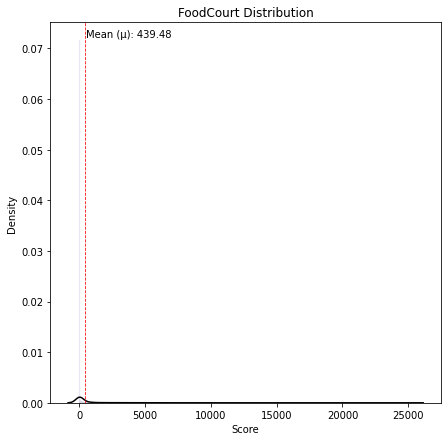

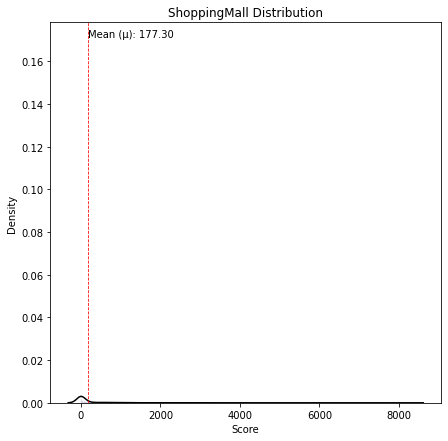

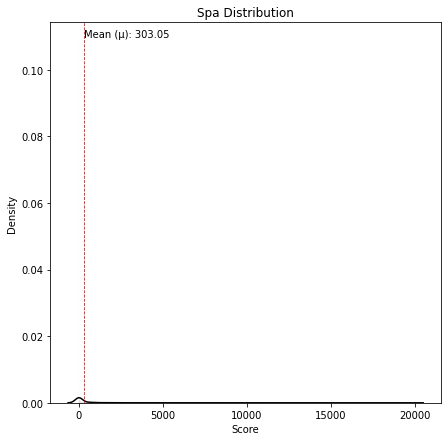

In [20]:
for column_name in numeric_features:
  plt.figure(figsize=(7, 7))
  plt.title("{column_name} Distribution".format(column_name = column_name))
  sns.histplot(test[column_name], stat='density',color='#E6E6FA')
  sns.kdeplot(test[column_name], color='black')
  plt.axvline(test[column_name].mean(), color='red', linestyle='--', linewidth=0.8)
  min_ylim, max_ylim = plt.ylim()
  plt.text(test[column_name].mean()*1.05, max_ylim*0.96, 'Mean (μ): {:.2f}'.format(test[column_name].mean()))
  plt.xlabel("Score")
  plt.ylabel("Density")
  plt.show()

Conclusion: the Age variable is close to the normal distribution. The variables characterizing passenger purchases have a maximum distribution density at zero.

Let's build boxplots of these variables for both datasets.

In [21]:
for column_name in numeric_features:
  fig = go.Figure()
  fig.add_trace(go.Box(y=train[column_name], name=column_name))
  fig.update_layout(title=column_name,
                                    yaxis_title="Value")
  fig.show()

In [22]:
for column_name in numeric_features:
  fig = go.Figure()
  fig.add_trace(go.Box(y=test[column_name], name=column_name))
  fig.update_layout(title=column_name,
                                    yaxis_title="Value")
  fig.show()

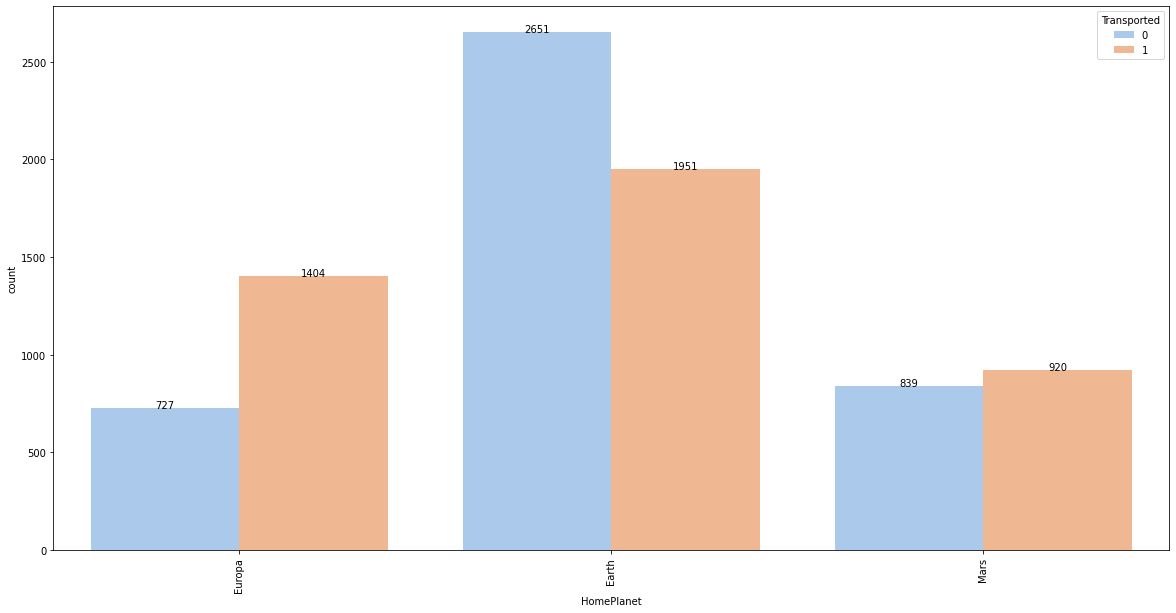

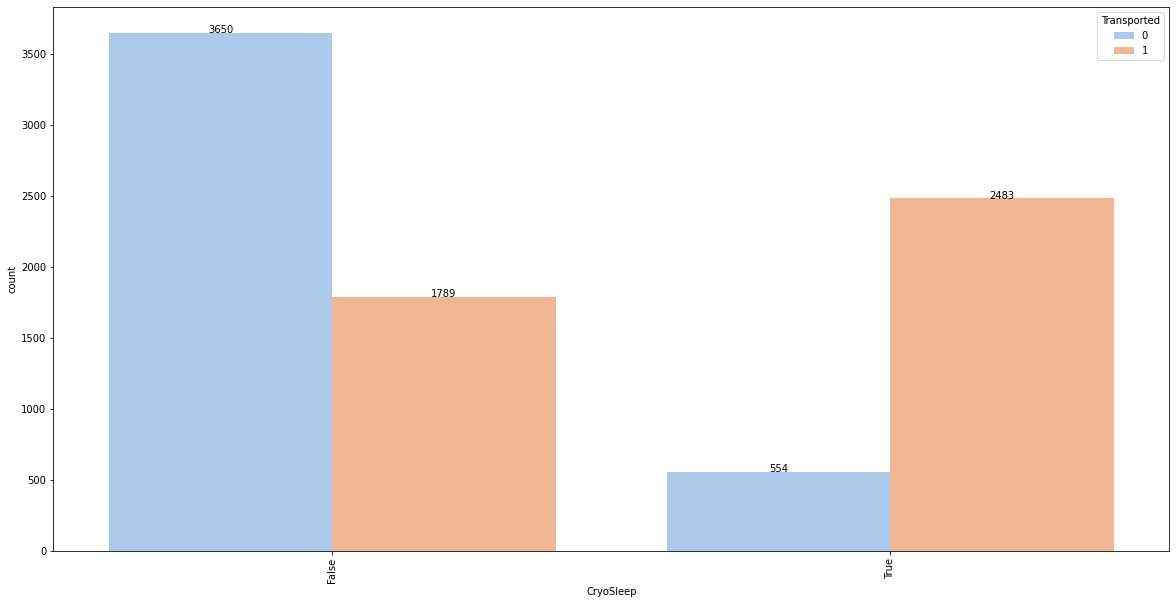

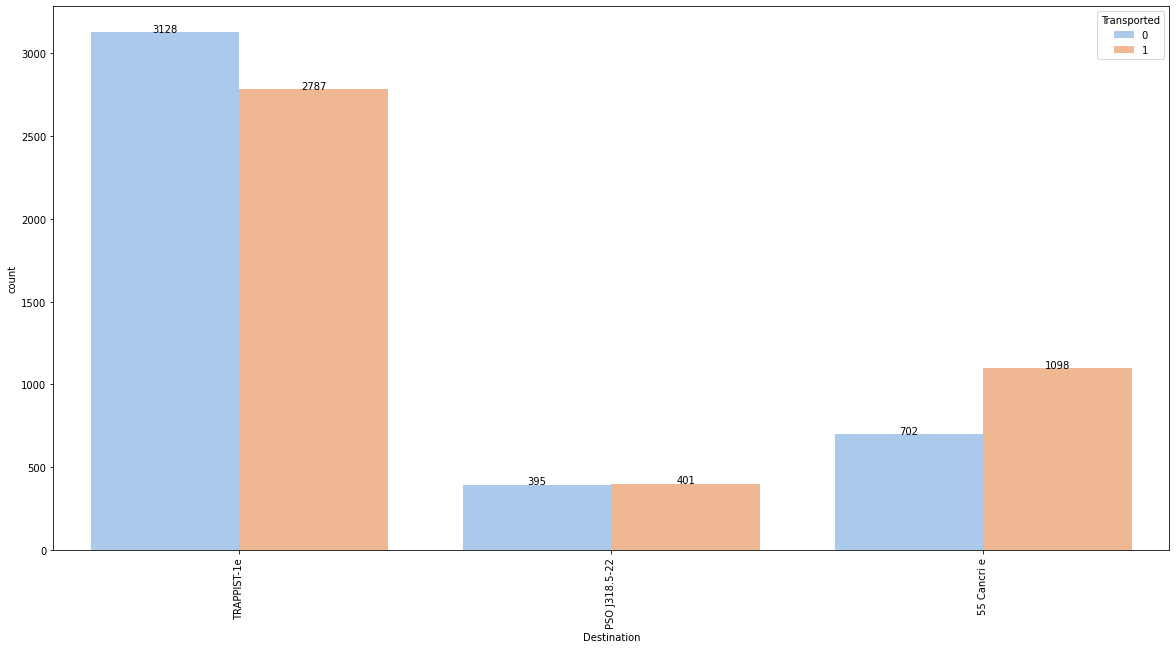

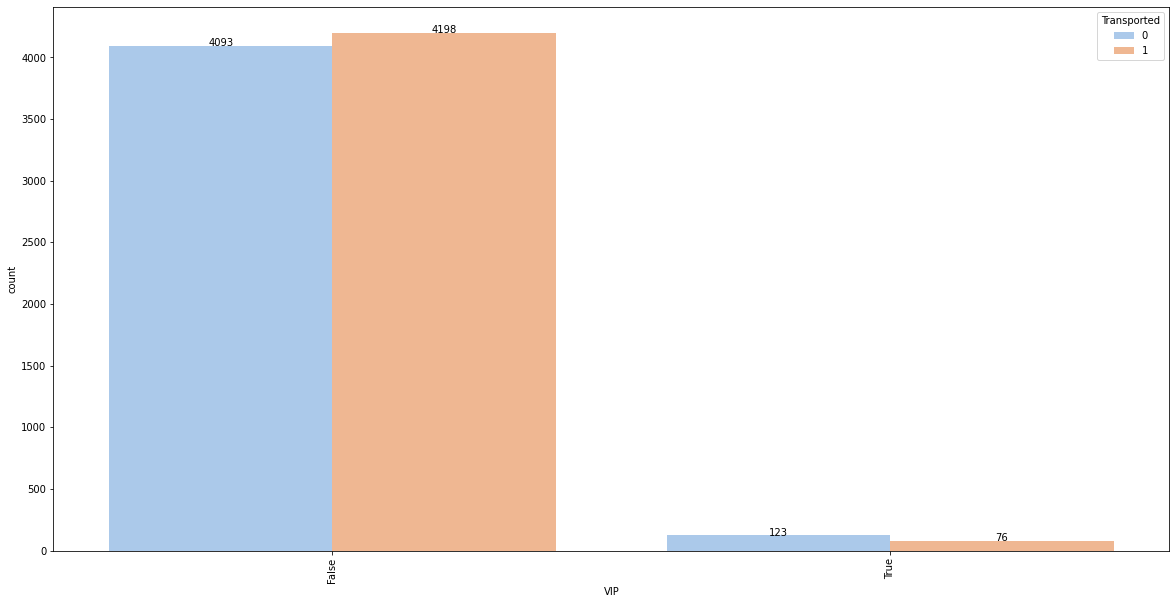

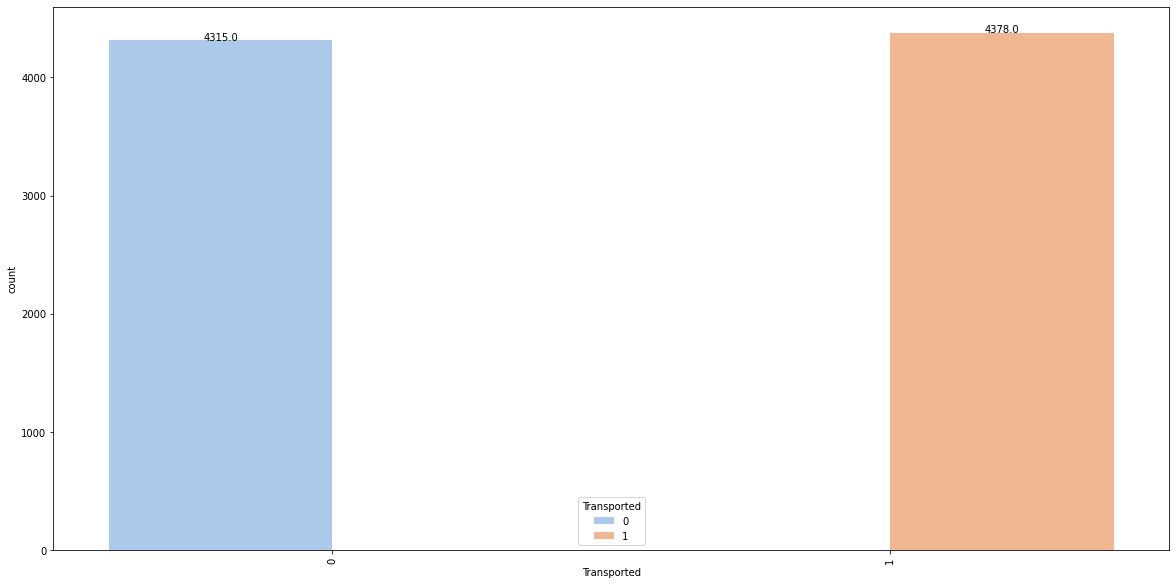

In [23]:
categorical_features=['HomePlanet','CryoSleep','Destination','VIP','Transported']

for feature in categorical_features:
  fig, ax1 = plt.subplots(figsize=(20,10))
  graph = sns.countplot(ax=ax1,x = feature , data = train,hue='Transported',palette='pastel')
  graph.set_xticklabels(graph.get_xticklabels(),rotation=90)
  for p in graph.patches:
    height = p.get_height()
    graph.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")

**Hypotheses:**

* the farther from the Earth a passenger flies, the more chances he has to survive.
* cryogenic sleep has a positive effect on the target variable.
* VIP status and destination do not affect the target variable.
* the target variable is almost balanced.

### Distribution Of Categorical features

In [30]:
for feature in categorical_features:
    if feature not in['Passenger_group','firstname','last_name','Cabin_no.']:

        df=train[feature].value_counts().reset_index()
        
        fig=px.pie(df,values=df.columns[1],names=df.columns[0],
                   labels={"index":"<b>"+feature,feature:"Count"},
                  color_discrete_sequence=px.colors.qualitative.Pastel)

        fig.update_layout(title="<b>"+feature, title_font_size=30,
                         font_size=20,
                         title_x=0.5,legend_bordercolor="#000",legend_borderwidth=2,
                         hoverlabel_font_size=20)
        fig.update_traces(marker=dict( line=dict(color='#000000', width=2)))              
        fig.show()


**Observation**
*     Homeplanet- most people was from Earth Followed by Europa, Mars
*     Cryosleep - most people was not in CryoSleep
*     Destination - mostly people was debarking to TRAPPIST-1e Followed by Canri e, PSO
*     Vip - frequency of non VIP people quite large Compared VIP people
*     Transported - no. of non transported is greater than transported people
*     No.inGroup - Majority of the were travellling alone in their group
*     Cabin Name- majority of people were in G and F cabin .
*     Cabin side-- NO of people on both sides is almost equal

In [10]:
train.isna().sum()

HomePlanet      201
CryoSleep       217
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Transported       0
deck            199
num             199
side            199
SumSpends         0
dtype: int64

In [11]:
test.isna().sum()

HomePlanet       87
CryoSleep        93
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
deck            100
num             100
side            100
SumSpends         0
dtype: int64

In [12]:
null_cols = train.isnull().sum().sort_values(ascending=False)
null_cols = list(null_cols[null_cols>1].index)
null_cols

['CryoSleep',
 'ShoppingMall',
 'VIP',
 'HomePlanet',
 'deck',
 'num',
 'side',
 'VRDeck',
 'FoodCourt',
 'Spa',
 'Destination',
 'RoomService',
 'Age']

In [13]:
object_cols = [col for col in train.columns if train[col].dtype == 'object' or train[col].dtype == 'category']
numeric_cols = [col for col in train.columns if train[col].dtype == 'float64']

print(f'Object cols -- {object_cols}')
print(f'Numeric cols -- {numeric_cols}')

Object cols -- ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'deck', 'num', 'side']
Numeric cols -- ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'SumSpends']


In [14]:
train[object_cols] = train[object_cols].astype('category')
test[object_cols] = test[object_cols].astype('category')

In [15]:
from sklearn.preprocessing import OrdinalEncoder

oc = OrdinalEncoder()

df_for_encode = pd.concat([train, test])

df_for_encode[object_cols] = df_for_encode[object_cols].astype('category')

df_for_encode[object_cols] = oc.fit_transform(df_for_encode[object_cols])

del train, test

train = df_for_encode.iloc[:8693, :]
test = df_for_encode.iloc[8693: , :]

del df_for_encode

test.drop('Transported', inplace=True, axis=1)

In [16]:
test

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,deck,num,side,SumSpends
PassengerId,,,,,,,,,,,,,,
0013_01,0.0,1.0,2.0,27.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,1117.0,1.0,0.0
0018_01,0.0,0.0,2.0,19.0,0.0,0.0,9.0,0.0,2823.0,0.0,5.0,1228.0,1.0,2832.0
0019_01,1.0,1.0,0.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0
0021_01,1.0,0.0,2.0,38.0,0.0,0.0,6652.0,0.0,181.0,585.0,2.0,1.0,1.0,7418.0
0023_01,0.0,0.0,2.0,20.0,0.0,10.0,0.0,635.0,0.0,0.0,5.0,1339.0,1.0,645.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9266_02,0.0,1.0,2.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,553.0,1.0,0.0
9269_01,0.0,0.0,2.0,42.0,0.0,0.0,847.0,17.0,10.0,144.0,NaN,NaN,NaN,1018.0
9271_01,2.0,1.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1113.0,0.0,0.0


In [17]:
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer


ct = ColumnTransformer([("imp", SimpleImputer(strategy='mean'), null_cols)])
    
train[null_cols] = ct.fit_transform(train[null_cols])
test[null_cols] = ct.fit_transform(test[null_cols])

In [27]:
X = train.copy()
y = X.pop('Transported')

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=23)

In [19]:
!pip3 install catboost

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score

def predict_and_acc(model, verbose=None):
    
    if verbose == None:
        model = model()
        model.fit(X_train, y_train)
        predict = model.predict(X_test)
        cvs = cross_val_score(model, X, y, cv=4)
        print(f'The accuracy score of {str(model)} is {float(accuracy_score(y_test, predict))}')
        print(f'The cross validation of {str(model)} is:{cvs} with mean of {cvs.mean()}')
    else:
        model = model(verbose=verbose)
        model.fit(X_train, y_train)
        predict = model.predict(X_test)
        cvs = cross_val_score(model, X, y, cv=4)
        print(f'The accuracy score of {str(model)} is {float(accuracy_score(y_test, predict))}')
        print(f'The cross validation of {str(model)} is:{cvs} with mean of {cvs.mean()}')

In [21]:
predict_and_acc(RandomForestClassifier, None)

The accuracy score of RandomForestClassifier() is 0.8031278748850046
The cross validation of RandomForestClassifier() is:[0.76172953 0.76898297 0.7947538  0.78601012] with mean of 0.7778691061285298


In [22]:
predict_and_acc(AdaBoostClassifier)

The accuracy score of AdaBoostClassifier() is 0.7980680772769089
The cross validation of AdaBoostClassifier() is:[0.74931003 0.78416935 0.79337322 0.80901979] with mean of 0.7839680959471239


In [23]:
predict_and_acc(XGBClassifier)

The accuracy score of XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...) is 0.7948482060717571
The cross validation of XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=

In [24]:
predict_and_acc(CatBoostClassifier, verbose=False)

The accuracy score of <catboost.core.CatBoostClassifier object at 0x7fd33d47d790> is 0.8054277828886844
The cross validation of <catboost.core.CatBoostClassifier object at 0x7fd33d47d790> is:[0.76310948 0.78324896 0.82144501 0.7947538 ] with mean of 0.7906393109208905


In [25]:
from sklearn.feature_selection import SequentialFeatureSelector

model_fs = CatBoostClassifier(verbose=False)
sf = SequentialFeatureSelector(model_fs, scoring='accuracy', direction = 'backward')
sf.fit(X,y)

SequentialFeatureSelector(direction='backward',
                          estimator=<catboost.core.CatBoostClassifier object at 0x7fd358a53c50>,
                          scoring='accuracy')

In [26]:
best_features = list(sf.get_feature_names_out())
best_features

['CryoSleep', 'RoomService', 'Spa', 'VRDeck', 'deck', 'side', 'SumSpends']

In [27]:
model = CatBoostClassifier(verbose=False, eval_metric='Accuracy')
model.fit(X[best_features], y)
prediction = model.predict(test[best_features])

In [28]:
final = pd.DataFrame()
final.index = test.index
final['Transported'] = prediction
final['Transported'].replace(0, False, inplace=True)
final['Transported'].replace(1, True, inplace=True)
final

,Transported
PassengerId,
0013_01,True
0018_01,False
0019_01,True
0021_01,True
0023_01,True
...,...
9266_02,True
9269_01,False
9271_01,True


In [29]:
final.to_csv('submission.csv')